In [1]:
%matplotlib inline
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, \
schedule_function, date_rules, time_rules
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import pandas as pd
import pyfolio as pf

Start date,2003-01-02
End date,2017-12-29
Total months,179
,Backtest
Annual return,4.1%
Cumulative returns,82.3%
Annual volatility,3.4%
Sharpe ratio,1.20
Calmar ratio,0.55
Stability,0.92
Max drawdown,-7.4%


/Users/lhon001/Development/anaconda3/envs/env_zipline/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.45,2008-05-13,2009-01-20,2009-07-24,314
1,5.44,2012-09-19,2013-04-19,2014-08-25,504
2,4.93,2006-01-13,2006-07-14,2006-11-13,217
3,4.65,2007-12-28,2008-02-26,2008-05-05,92
4,3.50,2015-02-23,2016-05-12,2017-02-01,508


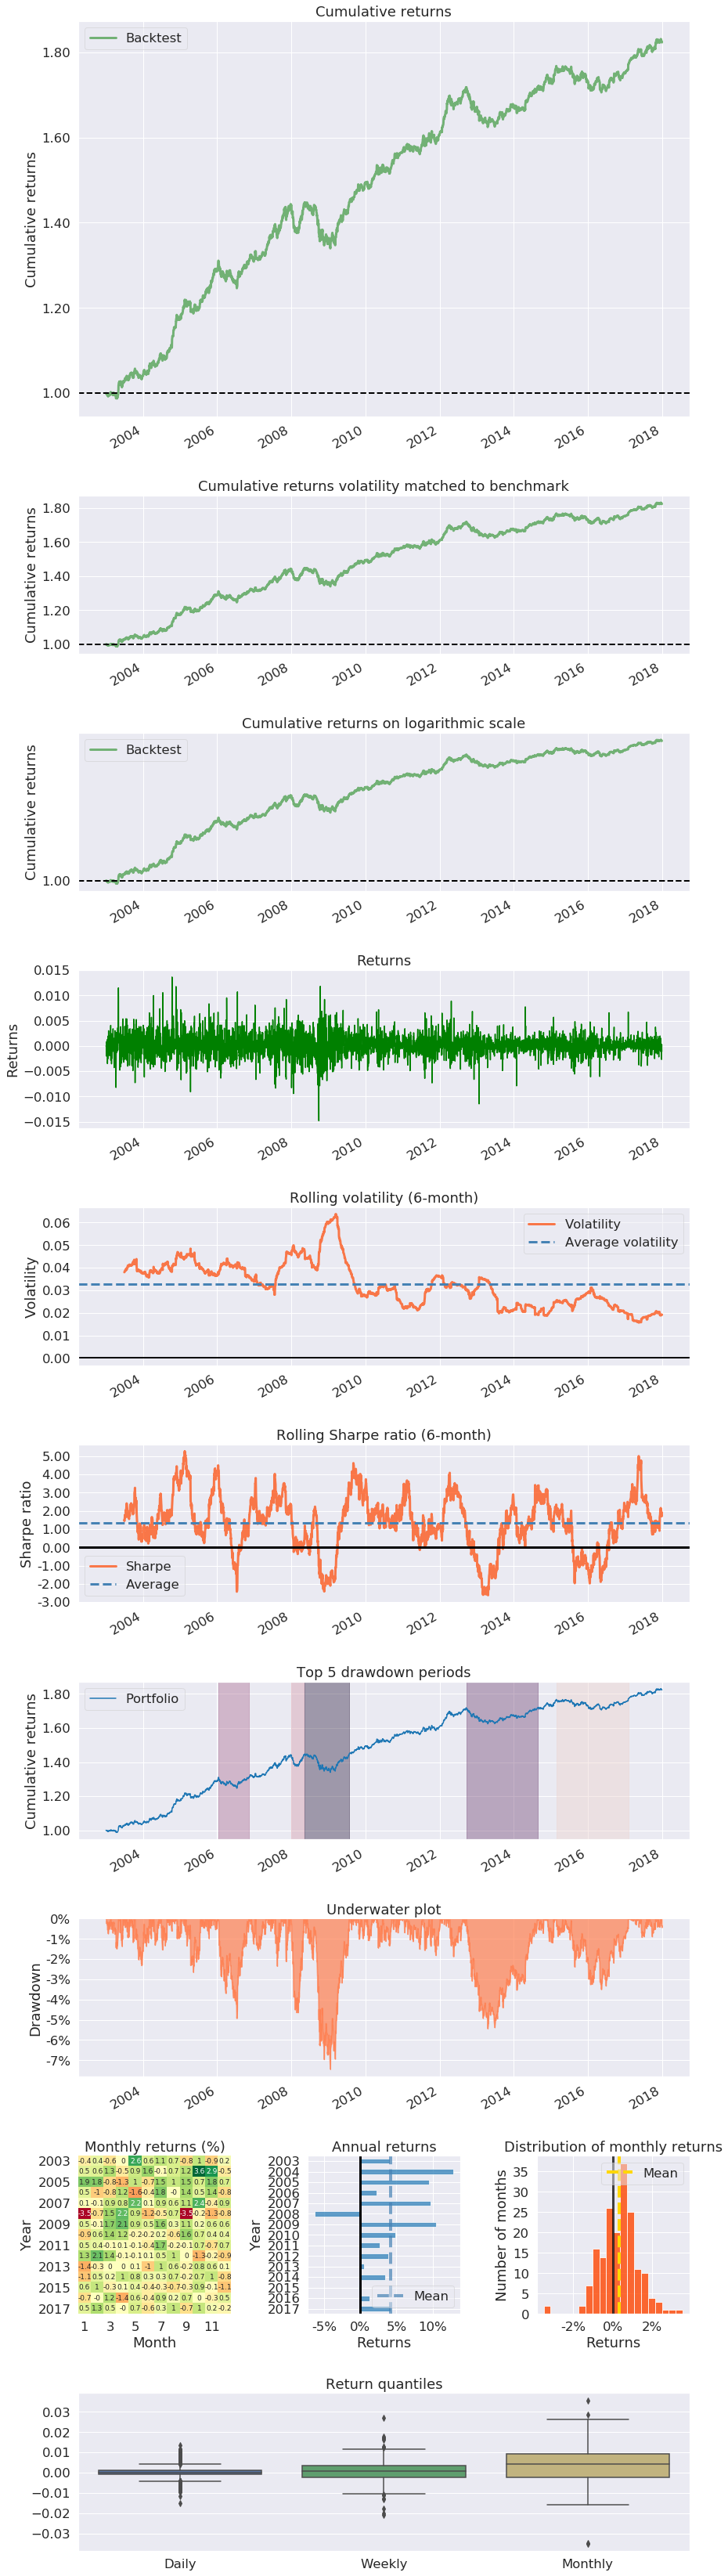

In [9]:
def initialize(context):
    # Which stocks to trade
#     dji = ["FB", "AMZN", "AAPL", "NFLX", "GOOG"]
    dji = ["AAPL"]
    
    # Make a list of symbols objects from the list of tickers
    context.dji_symbols = [symbol(s) for s in dji]
    
    # History window
    context.history_window = 20
    
    # Size of our portfolio
    context.stocks_to_hold = 10
    
    # Schedule the daily trading routine for once per month
    schedule_function(handle_data, date_rules.month_start(), time_rules.market_close())

# Check the month performance
# Take the last data point and divide by the first data point and subtract 1
def month_perf(ts):
    perf = (ts[-1] / ts[0]) - 1
    return perf
    
def handle_data(context, data):
    # Get historical data for all stocks in the data object
    stock_hist = data.history(context.dji_symbols, "close", context.history_window, "1d")
    
    # This creates a table of percent returns, in order. 
    # Here we are applying the month_perf() function on the stock_hist DataFrame
    perf_table = stock_hist.apply(month_perf).sort_values(ascending=False)
    
    # Make buy list of the top N stocks
    buy_list = perf_table[:context.stocks_to_hold]
    
    # The rest will not be held
    the_rest = perf_table[context.stocks_to_hold:]
    
    # Place target buy orders for top N stocks.
    for stock, perf in buy_list.iteritems():
        stock_weight = 1 / context.stocks_to_hold
        
        # Place order
        if data.can_trade(stock):
            order_target_percent(stock, stock_weight)
    
    # Make sure we are flat the rest
    for stock, perf in the_rest.iteritems():
        # Place order
        if data.can_trade(stock):
            order_target_percent(stock, 0.0)

def analyze(context, perf):
    # Use PyFolio to generate a performance report
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.create_returns_tear_sheet(returns, benchmark_rets=None)
    
# Set start and end date
start = datetime(2003, 1, 1, tzinfo=pytz.UTC)
end = datetime(2017, 12, 31, tzinfo=pytz.UTC)

# Fire off backtest; run_algorithm actually returns a dataframe
result = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    analyze=analyze,
    capital_base=10000,
    data_frequency='daily',
    bundle='quandl'
)